In [1]:
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme()

In [3]:
a = 20 # parameter a of the beta prior
b = 10 # parameter b of the beta prior
theta = 0.25 # true unknown parameter, P(HEAD)
n = 100 # number of coin tosses. Try 5000!

In [4]:
np.random.seed(42)
y = np.random.binomial(n, theta) # random number of heads from the distribution from a binomial distribution
#y = 24

# Practical lecture 1: Beta-Binomial, Gridding, Logarithmic tricks - Solutions

Let us consider a coin that lands heads with probability $\theta=0.25$ (unknown to us). 

Our prior knowledge of $\theta$ is encoded in a Beta distribution (where "success" corresponds to the coin landing heads), with parameters $a=20$ and $b=10$:

$$ \theta \sim \rm{Beta}(a,b).$$

That is, the prior probability density function (pdf) of $\theta$ is:
$$f_{\rm prior}(\theta) = \frac{1}{B(a, b)} \theta^{a-1} (1-\theta)^{b-1},\qquad \theta \in (0, 1).$$


We toss the coin $n=100$ times and observe a number $y=24$ of heads. How does our belief of $\theta$ change with the measurement?

Note: If you need the Beta probability distribution $\rm Beta$ in Python, use `scipy.stats.beta`. If you need the beta function $B$ in Python, it is `scipy.special.beta`.

## 0: Probabilistic model

* Derive and comment the full probabilistic model.

The full probabilistic model is:

\begin{align}
\theta \sim \rm{Beta}(a,b)\\
y \mid \theta \sim \rm{Bin}(n, \theta).
\end{align}

More explicitly, the prior probability density function (pdf) of $\theta$ is:
\begin{align}
f_{\rm prior}(\theta) = \frac{1}{B(a, b)} \theta^{a-1} (1-\theta)^{b-1},\qquad \theta \in (0, 1),
\end{align}
and the probability mass function of $y$, conditioned on $\theta$, is:
$$
P(y \mid \theta) = {{n}\choose{y}} \theta^{y} (1-\theta)^{n-y}.
$$


It is the classic Beta-binomial model. The random variable $y$ represents the number of success (heads) events over $n$ trials. The success probability $\theta$ is constant in all flips, which are (conditionally) independent events. For a given value of $\theta$, the probability of observing $y$ heads in $n$ trials is a binomial. The prior of $\theta$ is a Beta with *fixed* coefficients $a$ and $b$.

The Beta prior distribution is *conjugate* with the binomial likelihood, and thus the posterior of $\theta$ has a close-form Beta structure.

## 1: Prior distribution


* Plot the probability density function (pdf) of the prior $f_{\rm prior}(\theta)$. Explain our prior belief on $\theta$ in words.

The pdf of the prior is:

$$ f_{\rm prior}(\theta) = \frac{1}{B(a,b)} \theta^{a-1} (1-\theta)^{b-1}, \qquad \theta \in (0, 1),$$

where $B(a,b)$ is the [beta function](https://en.wikipedia.org/wiki/Beta_function) returning the right normalization constant such that $\int_{0}^1 f_{\rm prior}(\theta) \; d \theta = 1.$ <br/> 

In [5]:
# prior beta pdf defined manually
def prior_pdf(theta, a=20, b=10):
    return 1/scipy.special.beta(a,b) * theta**(a-1) * (1-theta)**(b-1) 

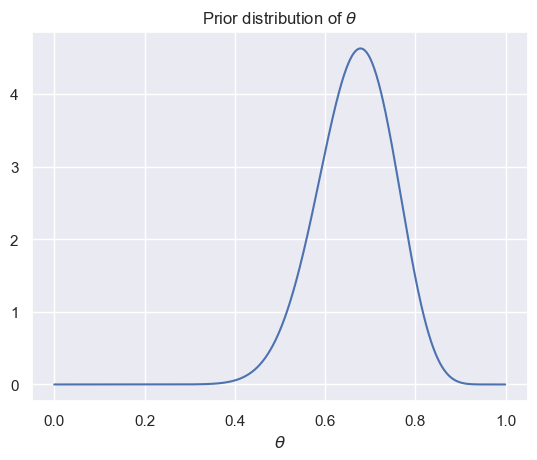

In [6]:
dtheta = 1e-3 # discretization step for theta
theta_vec = np.arange(0, 1, dtheta) # discretized theta range
plt.plot(theta_vec, prior_pdf(theta_vec))
# plt.plot(theta_vec, prior_pdf(theta_vec)) equivalent
plt.xlabel(r"$\theta$");
plt.title(r"Prior distribution of $\theta$");

According to our prior, the head outcome is more likely. This is in contrast with the underlying reality.

In [7]:
prior_var = stats.beta(a, b) # the .pdf method contains the probability density function

In [8]:
assert(np.allclose(prior_var.pdf(0.5) , prior_pdf(0.5))) # our implementation is close to scipy.stats

* Compute the mean, the mode, and the standard deviation of the prior distribution

In [9]:
# See formulas in the lecture notes "The beta-binomial model"
prior_mean = a/(a+b)
prior_mode = (a-1)/(a + b - 2)
prior_sd = np.sqrt(a*b/((a+b)**2*(a+b+1)))
prior_mean, prior_mode, prior_sd

(0.6666666666666666, 0.6785714285714286, np.float64(0.08466675133346033))

* Plot the prior distribution together with its mean, mode, and 95% HDI. Is the prior representative of the true value of $\theta$?

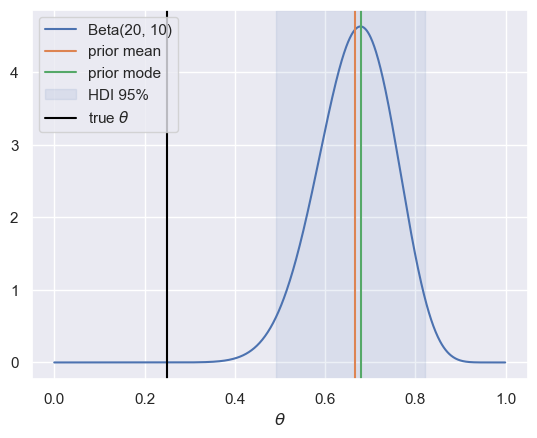

In [10]:
plt.plot(theta_vec, prior_var.pdf(theta_vec), color="C0", label="Beta(20, 10)")
plt.axvline(prior_mean, color="C1", label=r"prior mean")
plt.axvline(prior_mode, color="C2", label=r"prior mode")
# Also compute and plot the 95% HDI (Highest density interval) which contains 95% of the probability mass.
alpha = 0.05
L = prior_var.ppf(alpha/2)
H = prior_var.ppf(1-alpha/2) # ppf = percent point function
HDI = [L, H]
HDI
plt.axvspan(xmin=L, xmax=H, alpha=0.1, color="C0", label=r"HDI 95%")
plt.axvline(theta, color="black", label=r"true $\theta$")
plt.legend()
plt.xlabel(r"$\theta$");

The prior is not very representative of the true $\theta$. The bulk of the prior distribution is completely off, and the prior assigns a very small densities to points close to the true value 0.25.

## 2: Posterior distribution - exact derivation

* Obtain the posterior distribution in closed form.

The Beta-binomial model:
\begin{align}
\theta &\sim \mathrm{Beta}(a,b)\\
y \mid\theta &\sim \mathrm{Bin}(n, \theta)
\end{align}
is **conjugate**, meaning that the posterior distribution of $\theta$ given $y$ belongs to the same family as the prior.

It is well known that:
$$\theta \mid y \sim \mathrm{Beta}(a+y, b + n - y)$$
Which means:
$$f_{\rm post}(\theta) = f(\theta \mid y) = \frac{1}{B(a+y,b+n-y)} \theta^{a+y-1} (1-\theta)^{b+n-y-1}, \qquad \theta \in (0, 1).$$


The result can be derived from Bayes' rule:

\begin{equation*}
f(\theta \mid y) = \frac{P(y \mid \theta) f_{\rm prior}(\theta)}{P(y)} \propto \theta^{a+y-1} (1-\theta)^{b+n-y-1}.
\end{equation*}
Only a $\mathrm{Beta}$ random variable with parameters $a+y$ and $b+n-y$ has a pdf proportional to $\theta^{a+y-1} (1-\theta)^{b+n-y-1}$. The posterior is then a $\mathrm{Beta}(a+y, b + n - y)$.

In [11]:
a_post = a + y
b_post = b + n - y
post_var = stats.beta(a=a_post, b=b_post)

* Plot the posterior distribution together with the prior and the true value of $\theta$. Comment on the result.

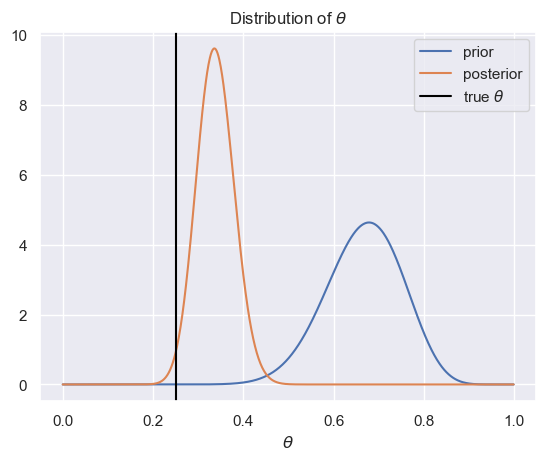

In [12]:
plt.plot(theta_vec, prior_var.pdf(theta_vec), label="prior")
plt.plot(theta_vec, post_var.pdf(theta_vec), label="posterior")
plt.axvline(theta, color="black", label=r"true $\theta$")
plt.legend()
plt.xlabel(r"$\theta$");
plt.title(r"Distribution of $\theta$");

The posterior $f(\theta | y)$ gets closer to the unknown true parameter $0.25$, despite the wrong prior assuption.

## 3: Likelihood

* Compute the likelihood function $\mathcal{L}(\theta) = P(y \mid \theta)$ on a grid, for fixed $y$ equal to the measured number of heads and values of $\theta$ in the numerical range $[0, \,1]$. You may disregard the multiplicative factor that does not depend on $\theta$.

In [13]:
def lik(theta):
    return (theta ** y) * (1 - theta)**(n-y)

lik_vec = lik(theta_vec)

In [14]:
def lik_exact(theta):
    return scipy.stats.binom.pmf(k=y, n=n, p=theta) # pmf = probability mass function

lik_vec_exact = lik_exact(theta_vec) # likelihood

* Plot the likelihood function. What do you notice?

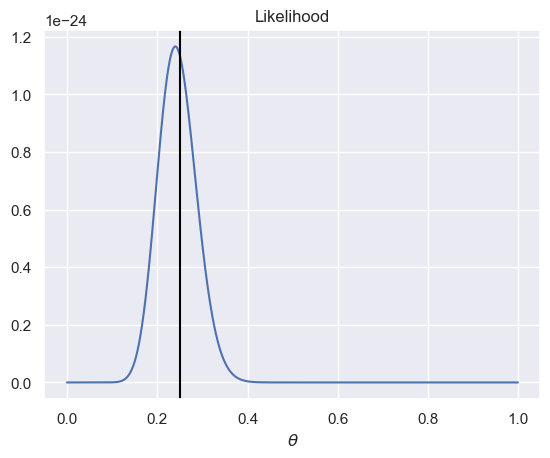

In [15]:
plt.plot(theta_vec, lik_vec)
#plt.axvline(theta_ml, color="red")
plt.axvline(theta, color="black", label=r"true $\theta$")
plt.xlabel(r"$\theta$");
plt.title("Likelihood");

* The maximum of the likelihood (maximum likelihood estimator) is a good point estimate for $\theta$.

* The likelihood function has a very bad numerical scale ($10^{-24}$), and it gets worse and worse for increasing values of $n$. In this case it still works (it falls within the float64 range), but we are close to the limit and we risk *numerical underflow*. In practice, we often work with the *logarithm* of the likelihood (and related quantities) to circumvent these numerical issues.

## 3. Point estimates

* Obtain the maximum likelihood (ML) point estimate $\theta^{\rm ml}$.

Hint: $\theta^{\rm ml}$ is the value of $\theta$ corresponding to the maximum of the likelihood function $\mathcal{L}(\theta)$:

$$\theta^{\rm ml} = \arg \max_{\theta} \mathcal{L}(\theta)$$

In [16]:
theta_vec[np.argmax(lik_vec)]

np.float64(0.24)

In [17]:

theta_ml = theta_vec[np.argmax(lik_vec)] # brute-force optimization
# theta_ml = y/n # ( in this case it can also be computed in closed-form!)
# theta_ml = scipy.optimize.minimize(lambda theta: -1e24*lik(theta), x0=0.5).x[0] # with numerical optimization
theta_ml

np.float64(0.24)

* Obtain the maximum a posteriori (MAP) point estimate

Hint: $\theta^{\rm MAP}$ is the value of $\theta$ corresponding to the maximum of the posterior density $f_{\rm post }(\theta)$.

In [18]:
# theta_map = theta_vec[np.argmax(post_var.pdf(theta_vec))] # brute-force numerical optimization
theta_map = (a_post-1)/(a_post+b_post-2) # analytical solution
theta_map = scipy.optimize.minimize(lambda theta: -post_var.pdf(theta), x0=0.5).x[0] # numerical solution (optimization)
theta_map

np.float64(0.3359374930124508)

* Obtain the posterior mean point estimate $E[\theta \mid y]$<br/>
Hint: You can use close-form formulas for the mean of the Beta random variable.

In this special case, we have a close formula for the posterior mean

In [19]:
theta_mean = (a_post)/(a_post+b_post); theta_mean # analytical solution 

0.3384615384615385

More in general, we could get a numerical approximation. By definition, we have:

$$
E[\theta \mid y] = \int_{0}^1 \theta f_{\rm post}(\theta)\; d\theta. 
$$

The integral above can be approximated numerically using the *multi-rectrangle* approximation as:
$$
\int_{0}^1 \theta f_{\rm post}(\theta)\; d\theta  
\approx 
\Delta \theta \sum_{i=0}^{N-1} \theta_i f_{\rm post}(\theta_i), \qquad \theta_i = i \Delta \theta, \Delta\theta = \frac{1}{N}.
$$

In [20]:
np.sum(theta_vec * post_var.pdf(theta_vec)) * dtheta # numerical solution (integration)

np.float64(0.3384615384615385)

## 4: Posterior distribution - gridding, aka brute-force approximation

* Obtain a numerical approximation of the posterior $f_{\rm post}(\theta)$, by normalizing the product $\mathcal{L}(\theta) \cdot f_{\rm prior}(\theta)$

By definition, the posterior distribution $f_{\rm post}(\theta)$ is:
$$f_{\rm post}(\theta) = f(\theta \mid  y) = \frac{\overbrace{P(y \mid \theta)}^{=\mathcal{L}(\theta)} \cdot f_{\rm prior}(\theta)}{P(y)},$$
where $P(y) = \int{P(y \mid\theta)\; d\theta}$.

Thus, $f_{\rm post}(\theta)$ corresponds to the product $\mathcal{L}(\theta) \cdot f_{\rm prior}(\theta)$, up to a multiplicative constant to be determined.

We have:
$$f_{\rm post}(\theta) = \frac{1}{Z} \cdot \mathcal{L}(\theta) f_{\rm prior}(\theta),$$

where the normalization constant $Z$ must be chosen to satisfy:

$$\int_\theta f_{\rm post}(\theta) \; d\theta = 1,$$
thus

$$Z = \int_\theta \mathcal{L}(\theta) f_{\rm prior}(\theta) \; d\theta = 1.$$

Any numerical integration method can be used to approximate the integral above. Easiest choice: Riemann sum on a uniform grid, with step size $\Delta \theta$
$$ Z \approx \Delta \theta \sum_{i} \mathcal{L}(\theta_i) f_{\rm prior}(\theta_i)$$

In [21]:
p_theta_post = lik_vec * prior_var.pdf(theta_vec)
Z = (np.sum(p_theta_post) * dtheta)
p_theta_post = p_theta_post/Z

**NOTE**: The Beta-Binomial case is a very special and lucky (conjugate) combination where we can compute $f_{\rm post}(\theta)$ analytically. The gridding approach above is also applicable to non-conjugate prior/likelihood combinations. However, it is only feasible in 1-3 dimensions as solving multi-dimensional integrals numerically becomes quickly intractable (curse of dimensionality!). For non-conjugate prior/likelihood combinations in higher dimensions, more advanced methods are needed. See following lectures!

* Verify that the numerical approximation of the posterior is accurate

In [22]:
np.allclose(p_theta_post, post_var.pdf(theta_vec))

True

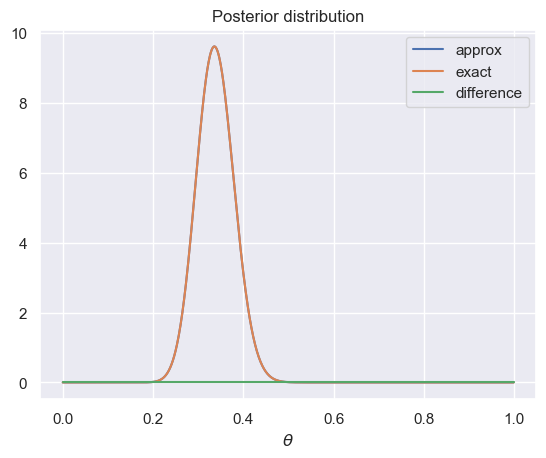

In [23]:
plt.plot(theta_vec, p_theta_post, label="approx")
plt.plot(theta_vec, post_var.pdf(theta_vec), label="exact")
plt.plot(theta_vec, p_theta_post - post_var.pdf(theta_vec), label="difference")
plt.xlabel(r"$\theta$");
plt.legend()
plt.title("Posterior distribution");

The numerical approximation is indeed accurate

* Obtain a scaled version of the likelihood function $\mathcal{L}(\theta)$, such that $\int_{0}^{1} \mathcal{L}(\theta)\; d\theta = 1$ and plot it. What does this function represent?

In [24]:
lik_vec_scaled = lik_vec/((np.sum(lik_vec) * dtheta))

The scaled likelihood may be seen as the posterior for a flat prior over $[0, 1]$. Such a flat prior is equivalent to a $\rm{Beta}(a=1,b=1).$

* Plot the posterior, the prior, and the scaled likelihood on the same axes. Comment the result.

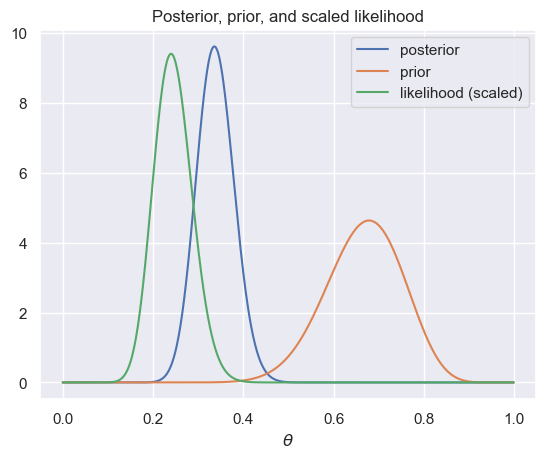

In [25]:
plt.plot(theta_vec, post_var.pdf(theta_vec), label="posterior")
plt.plot(theta_vec, prior_var.pdf(theta_vec), label="prior")
plt.plot(theta_vec, lik_vec_scaled, label="likelihood (scaled)")


plt.xlabel(r"$\theta$");
plt.legend()
plt.title("Posterior, prior, and scaled likelihood");

The posterior seems to be a trade-off between the prior (which pushes towards high values of $\theta$) and the scaled likelihood (which pushes towards lower values). Increasing the number of draws, the weight of the likelihood increases (the prior is overwhelmed by the posterior).

* Try to execute the code above with a larger value of n (ex. n = 5000). What happens? Why?

The numerical approximation of the likelihood/posterior fails due to numerical underflow.

## Enter the logarithm: log-likelihood and log-posterior

To avoid numerical difficulties, we may instead compute the *logarithm* of the likelihood and the posterior density. Starting from the definition:

$$f_{\rm post}(\theta) = f(\theta \mid y) = \frac{{P(y \mid \theta)} \cdot f_{\rm prior}(\theta)}{P(y)},$$

we obtain the following formula for the log-posterior $g(\theta) = \log f_{\rm post}(\theta)$:
$$g(\theta) = \log f_{\rm post}(\theta) = \overbrace{\log P(y \mid \theta)}^{=\ell(\theta)} + \log f_{\rm prior}(\theta) + \log P(y)$$

Let us compute the *log-likelihood* $\ell(\theta)$:

$$\ell(\theta) = \log \mathcal{L}(\theta) = \log P(y \mid \theta) = 
\log {{n}\choose{y}} \theta^{y} (1-\theta)^{(n-y)}=\log{{n}\choose{y}} + y \log \theta + (n-y) \log (1-\theta)$$

* Evaluate and plot the log-likelihood $\ell(\theta)$ up to an additive constant over a grid

In [26]:
def log_lik(theta):
    theta = np.where(theta==0, 1e-12, theta) # avoids a numerical issue for theta=0
    theta = np.where(theta==1, 1-1e-12, theta) # avoids a numerical issue for theta=1
    return y*np.log(theta)  + (n-y)*np.log(1 - theta)

log_lik_vec = log_lik(theta_vec) # log-likelihood, up to a constant additive factor

The numerical scaling of the log-likelihood is much better than the one of the likelihood.

* Evaluate and plot the log-prior $\log f_{\rm prior}(\theta)$ up to an additive additive constant over a grid

$$\log f_{\rm prior}(\theta) = \frac{1}{{B}(a,b)} \theta ^{a-1} (1-\theta)^{b-1} = 
- \log {B}(a, b) + (a-1)\log \theta + (b-1) \log (1-\theta)
$$

In [27]:
def log_prior(theta):
    theta = np.where(theta==0, 1e-12, theta) # avoids a numerical issue for theta=0
    theta = np.where(theta==1, 1-1e-12, theta) # avoids a numerical issue for theta=1
    return (a-1) * np.log(theta) + (b-1) * np.log(1-theta)

In [28]:
log_prior_vec = log_prior(theta_vec)
#log_prior_vec = prior_var.logpdf(theta_vec) # or just use scipy.stats...|

* Evaluate and plot the log-posterior $g(\theta)$ up to an additive constant over a grid

$$\log f(\theta \mid y) = \overbrace{\log P(y \mid \theta)}^{=\ell(\theta)} + \log f_{\rm prior}(\theta) + \log P(y)$$

In [29]:
log_post_vec = log_prior_vec + log_lik_vec # again, up to an additive constant

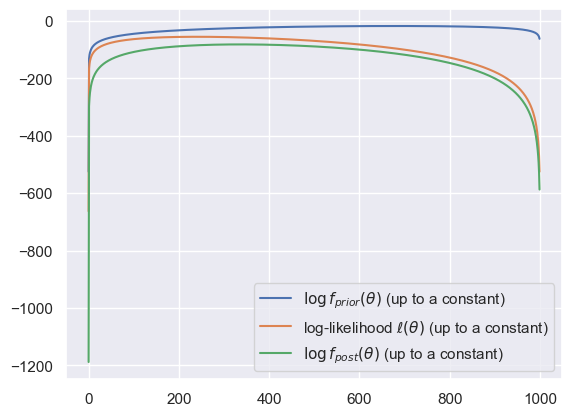

In [30]:
plt.plot(log_prior_vec, label=r"$\log f_{prior}(\theta)$ (up to a constant)")
plt.plot(log_lik_vec, label=r"log-likelihood $\ell(\theta)$ (up to a constant)")
plt.plot(log_post_vec, label=r"$\log f_{post}(\theta)$ (up to a constant)")
plt.legend();

* Obtain the normalized posterior $f(\theta \mid y)$ starting from the unnormalized log-posterior

In the variable `log_post_vec` we have a numerical value for $\log f_{\rm post}(\theta)$, up to an *additive* constant. Thus, in principle, `np.exp(log_post_vec)` we would have the posterior, up to a *multiplicative* constant.


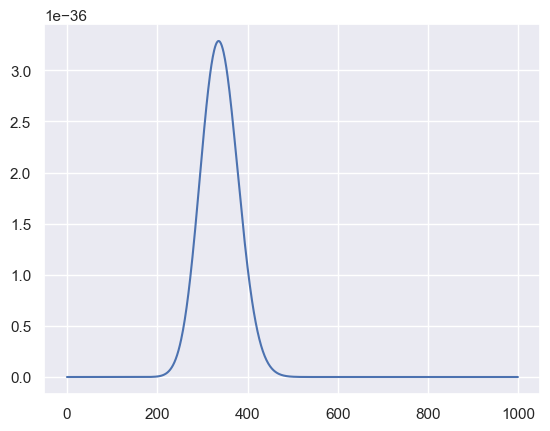

In [31]:
plt.plot(np.exp(log_post_vec));

This again may fail! Problems: numbers are too small! (for $n=5000$, $\approx e^{-2000}$, below machine epsilon). 



We can choose a better additive constant for the log-likelihood:

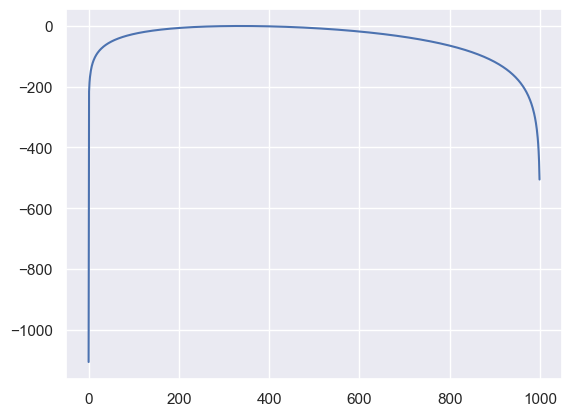

In [32]:
log_post_scaled = log_post_vec - np.max(log_post_vec)
plt.plot(log_post_scaled);

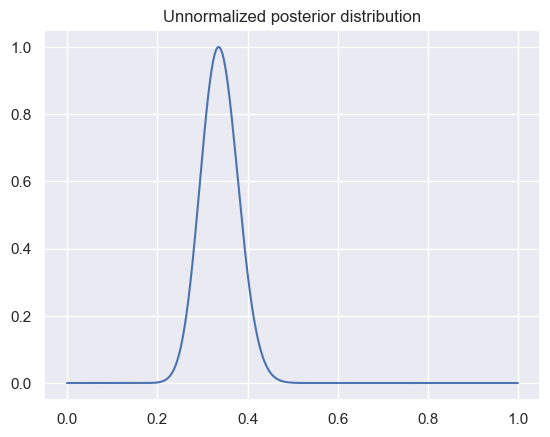

In [33]:
plt.title("Unnormalized posterior distribution")
plt.plot(theta_vec, np.exp(log_post_scaled));

Now it works! The maximum of the exponentiated function is $e^{0} = 1$. Now we just need to normalize it to be a probability distribution, which integrates to 1

In [34]:
post_unnorm = np.exp(log_post_scaled)
Z = np.sum(post_unnorm)*dtheta
post_norm = post_unnorm/Z

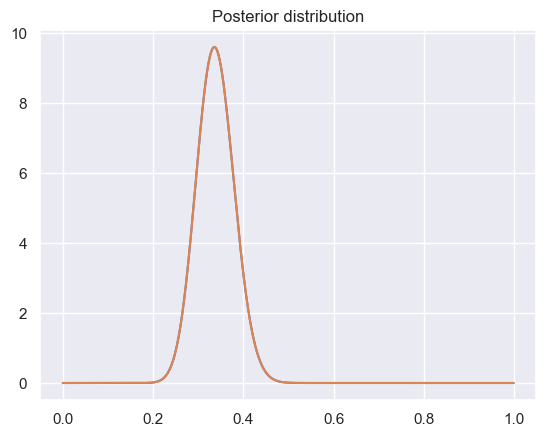

In [35]:
plt.title("Posterior distribution")
plt.plot(theta_vec, post_norm, label="Normalized")
plt.plot(theta_vec, post_var.pdf(theta_vec), label="Exact");

### Alternative implementation using the logsumexp

In the previous implementation, we have first added the constant ``-np.max(log_post)`` to the log-posterior for numerical reasons. We then exponentiated and finally normalized the result so that it integrates to 1.

There is another "magic" normalization constant that help us achieve the same result even more easily:

In [36]:
LSE = scipy.special.logsumexp(log_post_vec)
post_norm_ = np.exp(log_post_vec - LSE)

In [37]:
np.sum(post_norm_)

np.float64(1.0000000000000009)

The logsumexp function, applied to the array of log-probabilities ``log_post_vec``, return a constant LSE such that
``np.sum(np.exp(log_post_vec - LSE)) = 1``. We are almost there: we would like the *integral* to be one, thus:

In [38]:
post_norm = np.exp(log_post_vec - LSE)/dtheta

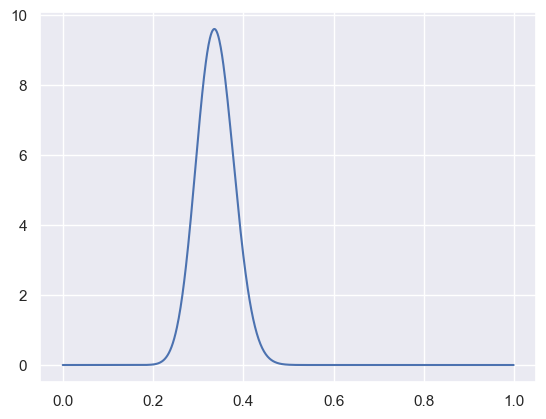

In [39]:
plt.plot(theta_vec, post_norm);

We have found a *magic constant* that provides a good scaling and the right normalization constant in one shot! How does it work?

## The logsumexp magic

Let us denote as $\tilde g(\theta)$ the log-posterior up to an additive constant $K$:

$$ \tilde g(\theta) = \log f_{\rm post}(\theta) + K \Rightarrow f_{\rm post}(\theta) = \frac{1}{Z} e^{\tilde g(\theta)}.$$

The constant $Z$ is such that $Z e^{\tilde g(\theta)}$ integrates to 1. Then,

$$ f_{\rm post}(\theta) = \frac{e^{\tilde g(\theta)}}{ \int{e^{\tilde g(\theta_i)}}\; d\theta}
\approx  \frac{e^{\tilde g(\theta)}}{\Delta \theta \sum_i{e^{\tilde g(\theta_i)}}} = 
\frac{e^{\tilde g(\theta)}}{\Delta \theta e^{\log \sum_i{e^{\tilde g(\theta_i)}}}} = \frac{1}{\Delta \theta} \frac{e^{\tilde g(\theta)}}{e^{\rm logsumexp(G)}} = \frac{1}{\Delta \theta}  e^{\tilde g(\theta) - \mathrm{logsumexp}(G)},$$
where $\mathrm{G} = [\tilde g(\theta_0), \tilde g(\theta_1), \dots, \tilde g(\theta_{n-1})]$ is the vector of the samples of $\tilde g$ at the grid points used for numerical integration of $\theta$.



* Internally, the logsumexp function avoid exponentiation with very small/very large numbers exploiting the identity:

$$ {\rm logsumexp}(x) = \log \sum_i e^{x_i} = c + \log \sum_i e^{(x_i - c)}.$$

* A robust implementation of logsumexp sets $c = \max(x_0, \dots, x_{n-1})$. This ensures that the largest exponentiated term is always $e^0=1$!


In [40]:
def logsumexp(x):
    c = x.max()
    return c + np.log(np.sum(np.exp(x - c)))


The logsumexp function is defined for a vector $\mathrm{x} = [x_0\; x_1\; \dots \; x_{n-1}]^\top$ as:

$$\mathrm{logsumexp}(\mathrm{x}) = \log \sum_i e^{x_i}.$$

Consider the following code:

* Whenever we have a summation in the original probability/likelihood domain, we can alternatively perform a logsumexp operation in the log-probability/log-likelihood domain. 

* Imagine we have a vector $x$ of log-probabilities and want to compute the sum of the probabilities. We have:
$$\sum_{i} e^{x_i}
% = \log e^{\overbrace{\log \sum_{i} e^{x_i}}^{= {\rm logsumexp}(x)}} 
= e^{{\rm logsumexp}(x)}.
%\log \left(\sum_{i} e^{x_i}\right) 
% = \log e^{\overbrace{\log \sum_{i} e^{x_i}}^{= {\rm logsumexp}(x)}} 
%= {{\rm logsumexp}(x)}.
$$

* If the probabilities $e^{x_i}$ are small (i.e., $x_i$ are negative values with a large modulus), direct evaluation of the left-hand side may fail and the logsumexp implementation at the right-hand side is to be preferred. 

* If we are interested in a result in the log-domain, the exponentiation at the right-hand side (which could also be problematic) is avoided.

* In general, it is suggested to perform as many operations as possible in the log-domain and go back to the original domain only when it is strictly necessary (and numerically safe!)